# 08. 리샘플링을 통한 모델 비교
- 두 개 이상의 모델을 만든 후 다음 단계는 이를 비교하여 어떤 모델이 가장 좋은지 이해하는 것
- 어떤 경우에는 동일한 모델이 다른 기능이나 전처리 방법을 사용하여 평가될 수 있는 모델 내에서 비교가 수행될 수 있으며, 또는 같은 모델 간 비교가 일반적인 시나리오입니다.

- 두 경우 모두 결과는 각 모델에 대해 리샘플링된 요약 통계량의(예: RMSE, 정확도 등) 모음

<br>



## 08.01 워크플로를 사용하여 여러 모델 생성
- 전처리 단계를 점진적으로 추가하는 세 가지 선형 모델 생성
    - 추가 항이 모델 결과를 향상하는지 여부를 테스트

In [6]:
library(tidymodels)
tidymodels_prefer()

In [7]:
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

- 일반 다항회귀

In [8]:
basic_rec <- recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude, data = ames_train) %>%
    step_log(Gr_Liv_Area, base = 10) %>% 
    step_other(Neighborhood, threshold = 0.01) %>% 
    step_dummy(all_nominal_predictors())

- 상호작용항 추가

In [9]:
interaction_rec <- basic_rec %>% 
    step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) 

- 스플라인항 추가

In [10]:
spline_rec <- interaction_rec %>% 
    step_ns(Latitude, Longitude, deg_free = 50)

<br>

#### 워크플로셋 생성

In [31]:
preproc <- list(basic = basic_rec,
                interact = interaction_rec,
                splines = spline_rec)

- 모든 모델에 대하여 선형회귀 워크플로 생성

In [32]:
lm_models <- workflow_set(preproc, list(lm = linear_reg()), cross = FALSE)
print(lm_models)

# A workflow set/tibble: 3 × 4
  wflow_id    info             option    result    
  <chr>       <list>           <list>    <list>    
1 basic_lm    <tibble [1 × 4]> <opts[0]> <list [0]>
2 interact_lm <tibble [1 × 4]> <opts[0]> <list [0]>
3 splines_lm  <tibble [1 × 4]> <opts[0]> <list [0]>


<br>

#### 각 모델을 차례로 리샘플링

- 10-fold

In [33]:
set.seed(1001)
ames_folds <- vfold_cv(ames_train, v = 10)

- 리샘플링 옵션 설정

In [34]:
keep_pred <- control_resamples(save_pred = T, save_workflow = T)

- **`purrr::workflow_map()`을 통하여, `fit_resamples()`함수를 모든 모델에 일괄 적용**

In [35]:
lm_models <- lm_models %>% 
    workflow_map("fit_resamples", 
                seed = 1101, verbose = TRUE,
                resamples = ames_folds, control = keep_pred)

i 1 of 3 resampling: basic_lm

✔ 1 of 3 resampling: basic_lm (581ms)

i 2 of 3 resampling: interact_lm

✔ 2 of 3 resampling: interact_lm (701ms)

i 3 of 3 resampling: splines_lm

✔ 3 of 3 resampling: splines_lm (1.3s)



In [36]:
print(lm_models)

# A workflow set/tibble: 3 × 4
  wflow_id    info             option    result   
  <chr>       <list>           <list>    <list>   
1 basic_lm    <tibble [1 × 4]> <opts[2]> <rsmp[+]>
2 interact_lm <tibble [1 × 4]> <opts[2]> <rsmp[+]>
3 splines_lm  <tibble [1 × 4]> <opts[2]> <rsmp[+]>


<br>

#### 모델별 성능 확인

In [38]:
collect_metrics(lm_models) %>% filter(.metric == "rmse")

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.08032984,10,0.002641246
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07990482,10,0.002724045
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07848118,10,0.002824448


<br>

#### 랜덤포레스트 워크플로 생성후 워크플로셋에 추가

In [39]:
rf_model <- rand_forest(trees = 1000) %>% 
    set_engine("ranger") %>% 
    set_mode("regression")

In [40]:
rf_wflow <- workflow() %>% 
    add_formula(
    Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude) %>% 
    add_model(rf_model)

In [41]:
rf_res <- rf_wflow %>%
    fit_resamples(resamples = ames_folds, control = keep_pred)

In [42]:
four_models <- as_workflow_set(random_forest = rf_res) %>% 
    bind_rows(lm_models)

print(four_models)

# A workflow set/tibble: 4 × 4
  wflow_id      info             option    result   
  <chr>         <list>           <list>    <list>   
1 random_forest <tibble [1 × 4]> <opts[0]> <rsmp[+]>
2 basic_lm      <tibble [1 × 4]> <opts[2]> <rsmp[+]>
3 interact_lm   <tibble [1 × 4]> <opts[2]> <rsmp[+]>
4 splines_lm    <tibble [1 × 4]> <opts[2]> <rsmp[+]>


<br>

#### 모델 비교 - 각 모델에 대한 $R^2$의 신뢰 구간
- 각 모델별 모든 fold의 $R^2$의 범위 확인
    
    $\rightarrow$ 랜덤 포레스트 모델이 가장 높은 성능,
    
    선형회귀 모델에서는 스플라인 항이 추가된 모델이 가장 높은 성능

In [43]:
library(ggrepel)

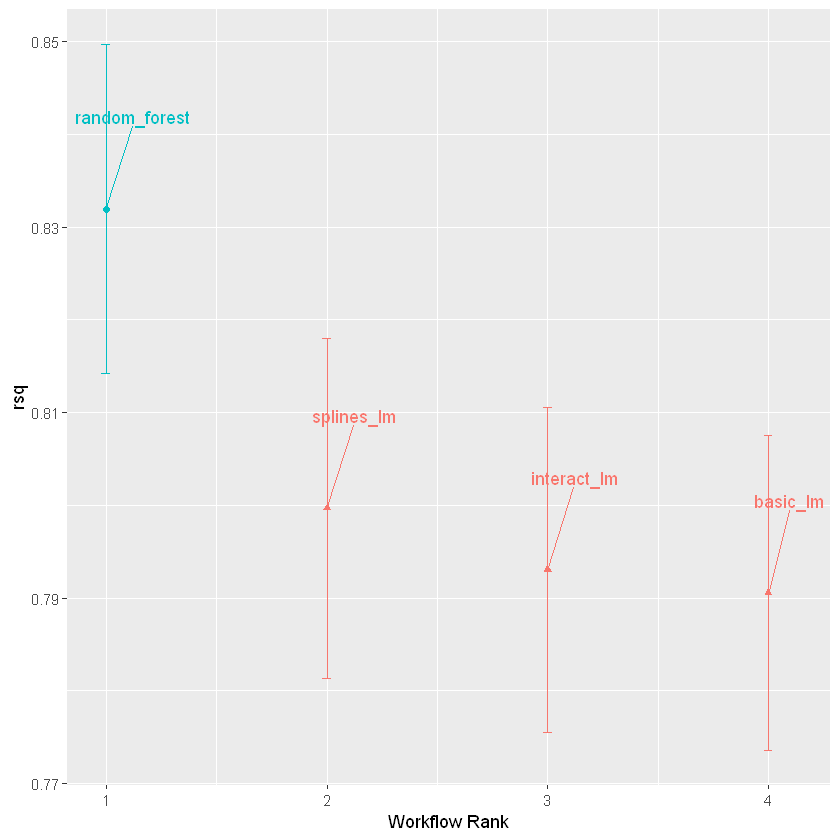

In [44]:
autoplot(four_models, metric = "rsq") +
    geom_text_repel(aes(label = wflow_id), nudge_x = 1/8, nudge_y = 1/100) +
    theme(legend.position = "none")

<br>

## 08.02. 리샘플링 성능 비교
- 모델 간 비교를 수행하기 전, 리샘플내 상관 관계를 고려하는 것이 중요

- **모든 모델 전반에 걸쳐 성능이 낮은 경향이 있는 일부 리샘플과, 높은 경향이 있는 리샘플이 존재**
    
    $\rightarrow$ **리샘플-변동 구성요소 (resample-to-resample component of variation.)**

<br>

#### 선형회귀 모델과 랜덤포레스트 모델에 대한 개별 리샘플링 통계량 확인

In [47]:
rsq_indiv_estimates <- collect_metrics(four_models, summarize = FALSE) %>% 
    filter(.metric == "rsq")

- 각 모델-fold 별 $R^2$ (= 각 모델의 실제값과 예측값 간 상관관계)

In [48]:
rsq_wider <- rsq_indiv_estimates %>%
    select(wflow_id, .estimate, id) %>%
    pivot_wider(id_cols = "id", names_from = "wflow_id", values_from = ".estimate")

In [49]:
rsq_wider

id,random_forest,basic_lm,interact_lm,splines_lm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Fold01,0.8613243,0.8108089,0.8133956,0.8217386
Fold02,0.8629144,0.8044946,0.8102542,0.8165407
Fold03,0.8800802,0.8435443,0.8505363,0.8584183
Fold04,0.8206735,0.7777345,0.7820878,0.7818266
Fold05,0.8521175,0.8246588,0.8228630,0.8329950
Fold06,0.8218848,0.7873930,0.7814756,0.8014066
Fold07,0.8506892,0.7938588,0.7990242,0.8017741
Fold08,0.7852732,0.7782360,0.7841606,0.7857750
Fold09,0.7881615,0.7438445,0.7424806,0.7502031


<br>

- **각 모델별 $R^2$의 상관관계 : 전반적으로 높은 상관관계**

    $\rightarrow$ **모델 전반에 걸쳐 리샘플 내 상관관계가 높다는 것을 의미**

In [50]:
corrr::correlate(rsq_wider %>% select(-id))

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


term,random_forest,basic_lm,interact_lm,splines_lm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
random_forest,NA,0.8878132,0.8905391,0.8882616
basic_lm,0.8878132,NA,0.9925417,0.9971345
interact_lm,0.8905391,0.9925417,NA,0.9866937
splines_lm,0.8882616,0.9971345,0.9866937,NA


- **리샘플-변동 구성요소의 효과가 크지 않은 경우, 평행선은 존재하지 않음**

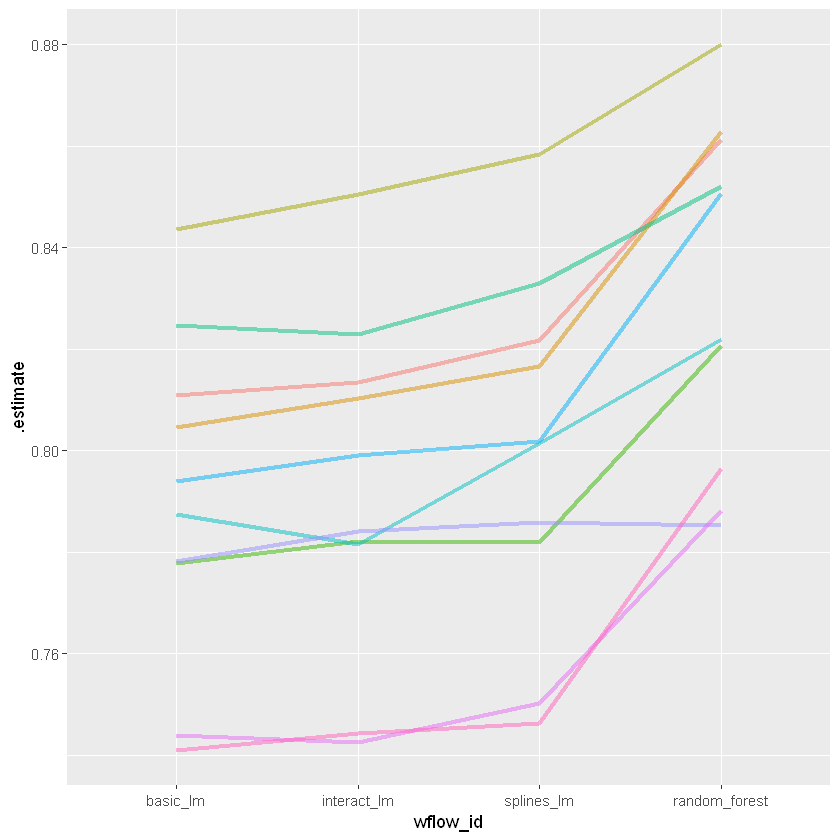

In [51]:
rsq_indiv_estimates %>% 
    mutate(wflow_id = reorder(wflow_id, .estimate)) %>% 
    ggplot(aes(x = wflow_id, y = .estimate, group = id, color = id)) + 
    geom_line(alpha = .5, linewidth = 1.25) + 
    theme(legend.position = "none")

- 상관관계에 대한 통계적 검정을 통해, 상관관계의 크기가 단순한 노이즈인지 여부를 확인
    - 일반 다항회귀 모델과, 스플라인 회귀모델의 상관성은 유의한 것으로 판단
    
    - 상관관계의 추정치 및 신뢰구간은 리샘플 내 상관관계가 유의하다는 근거

In [56]:
rsq_wider %>%
    with(cor.test(basic_lm, splines_lm)) %>%
    tidy() 

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
0.9971345,37.28141,2.939718e-10,8,0.9874529,0.999348,Pearson's product-moment correlation,two.sided


<br>

#### 상관관계의 의미
- 두 변수의 분산간 차이

$$\operatorname{Var}[X - Y] = \operatorname{Var}[X] + \operatorname{Var}[Y]  - 2 \operatorname{Cov}[X, Y]$$

- **위 식의 마지막 항인 두 항목 간의 공분산이 클 경우, 이 차이에 대한 통계적 검정은 두 모델의 차이를 비교하는 데 매우 효과적이지 않음**

    $\rightarrow$ **즉, 리샘플-변동 구성요소의 효과를 무시하면 모델 간 차이가 없는 쪽으로 비교 결과가 편향됨**

<br>

#### 모델 비교
- 모델 비교에 있어 중요한 요인은 성능과 주관성

<br>

## 08.03. 가설 검정
- 가설 검정을 통한 모델 간 비교 수행
- 아래와 같은 선형회귀 모델을 가정

$$y_{ij} = \beta_0 + \beta_1x_{i1} + \ldots + \beta_px_{ip} + \epsilon_{ij}$$

- 위와 같은 다항회귀 모델 생성과, 그룹 간 비교를 위해 널리 사용되는 분산분석 (ANOVA)에서, 설명변수는 범주형 변수에 대한 가변수 
- 분산분석과 $\beta$를 통하여 두 개 이상의 범주가 서로 다른지 여부를 측정

<br>

#### ANOVA를 통한 모델 비교
- 각 리샘플의 $R^2$가 ANOVA에서의 반응변수($y_{ij}$) 이라고 할 때, 각 모델은 ANOVA에서의 $x_i$라고 가정한다면,

<table class="table" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>
<span id="tab:model-anova-data">
</caption>
<thead>
<tr>
<th style="text-align:right;">
Y = rsq
</th>
<th style="text-align:left;">
model
</th>
<th style="text-align:right;">
X1
</th>
<th style="text-align:right;">
X2
</th>
<th style="text-align:right;">
X3
</th>
<th style="text-align:left;">
id
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:right;">
0.8108
</td>
<td style="text-align:left;">
basic_lm
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:left;">
Fold01
</td>
</tr>
<tr>
<td style="text-align:right;">
0.8134
</td>
<td style="text-align:left;">
interact_lm
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:left;">
Fold01
</td>
</tr>
<tr>
<td style="text-align:right;">
0.8615
</td>
<td style="text-align:left;">
random_forest
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:left;">
Fold01
</td>
</tr>
<tr>
<td style="text-align:right;">
0.8217
</td>
<td style="text-align:left;">
splines_lm
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:left;">
Fold01
</td>
</tr>
<tr>
<td style="text-align:right;">
0.8045
</td>
<td style="text-align:left;">
basic_lm
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:left;">
Fold02
</td>
</tr>
<tr>
<td style="text-align:right;">
0.8103
</td>
<td style="text-align:left;">
interact_lm
</td>
<td style="text-align:right;">
1
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:right;">
0
</td>
<td style="text-align:left;">
Fold02
</td>
</tr>
</tbody>
</table>

- 모델 비교를 위한 ANOVA는 

$$y_{ij} = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \beta_3x_{i3} + \epsilon_{ij}$$이며,

- $\beta_0$ : `basic_lm` 모델 (단순 다항회귀)의 $R^2$ 평균 
- $\beta_1$ : 상호작용항 모델과 단순 다항회귀간의 $R^2$ 평균의 변화량
- $\beta_2$ : 랜덤포레스트 모델과 단순 다항회귀간의 $R^2$ 평균의 변화량
- $\beta_3$ : 스플라인항 모델과 단순 다항회귀간의 $R^2$ 평균의 변화량
    

<br>

- 가설 검정과 p-값이 생성되어 모델을 통계적으로 비교하지만, 리샘플 변동 구성요소의 효과를 처리하는 방법에 대해 고려 필요

- **리샘플을 랜덤효과로 처리하여 ANOVA 모델을 적합하는 방법은 선형 혼합 모델 ( Faraway 2016 ) 또는 베이지안 계층적 모델에 해당**

<br>

####  t-검정을 통한 모델 비교

In [57]:
compare_lm <- rsq_wider %>% 
    mutate(difference = splines_lm - basic_lm)

In [58]:
lm(difference ~ 1, data = compare_lm) %>% 
    tidy(conf.int = TRUE) %>% 
    select(estimate, p.value, starts_with("conf"))

estimate,p.value,conf.low,conf.high
<dbl>,<dbl>,<dbl>,<dbl>
0.009131344,2.563969e-05,0.006501232,0.01176146


- 두 모델간 각 fold별 $R^2$ 차이는 통계적으로 유의

In [62]:
rsq_wider %>% 
    with( t.test(splines_lm, basic_lm, paired = TRUE) ) %>%
    tidy()

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.009131344,7.853861,2.563969e-05,9,0.006501232,0.01176146,Paired t-test,two.sided


<br>

## 08.04. 베이지안 방법
- 무작위 효과와 베이지안 통계를 사용하여 이러한 공식 비교를 수행하는 보다 일반적인 접근 방식 가능 ( McElreath 2020 ) 
- ANOVA 방법보다 더 복잡하지만 해석은 더 간단
- ANOVA 모델의 형식

$$y_{ij} = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \beta_3x_{i3} + \epsilon_{ij}$$

<br>

#### 통계적 가정
- 잔차 $\epsilon_{ij}$는 독립성을 띄는 것으로 가정되고,평균이 0이고 표준편차가 $\sigma$인 정규분포를 따른다고 가정
- 베이지안 방법은 잔차에 대한 분포를 지정하는 것 외에도, 모델의 매개변수에 대한 사전분포를 지정 ($\beta_{j}, \sigma$)

$$\begin{align}
\epsilon_{ij} &\sim N(0, \sigma) \notag \\
\beta_j &\sim N(0, 10) \notag \\
\sigma &\sim \text{exponential}(1) \notag
\end{align}$$

- 이러한 사전분포 설정을 통하여 매개변수에 대한 확률적이고 가능한 범위를 지정
    - $\sigma$에 대한 사전분포는 $\sigma$값이 0보다 커야 하고 매우 오른쪽으로 치우쳐 있으며 일반적으로 3 또는 4보다 작은 값을 가짐을 나타냄
    
    * $\beta_{ij}$의 사전분포는 표준편차가 10으로 매우 넓음

        $\rightarrow$ 정규분포의 대칭성, 종모양이라는 점을 제외하면 사전적인 범위가 선명하지 않으며, 사전분포가 크다는 것은 사전 정보가 많지 않음을 의미
        
- 관측 데이터와 사전분포를 통해 각 매개변수별 사후분포를 추정

<br>

### 무작위 절편 모델
- 리샘플이 적절하게 모델링되도록, 베이지안 분산분석 모델에 무작위 절편 모델을 고려
    
    $\rightarrow$ 리샘플이 절편을 변경해야만 모델에 영향을 미친다는 가정
    
    $\rightarrow$ 리샘플이 회귀 매개변수에 이상치같은 영향을 미치는 것을 제한
    
    $\rightarrow$ 리셈플 전체에서 동일한 관계를 갖는 것으로 가정
    
$$y_{ij} = (\beta_0 + b_{i}) + \beta_1x_{i1} + \beta_2x_{i2} + \beta_3x_{i3} + \epsilon_{ij}$$

- **이 모델 구성의 경우, 무작위 효과의 사전분포에 대한 추가적인 가정이 필요** 
    - fold가 10개인 경우, 표준정규분포보다 더 넓은 t-분포를 사용 (i,e $b_i \sim t(1)$)

<br>

- 워크플로 세트의 경우, 그룹이 워크플로인 분산분석 모델을 생성
- 기존 ANOVA는 튜닝 매개변수를 설정하지 않았으나, 
    
    워크플로 세트중 하나에, 튜닝이 필요한 매개변수에 대한 데이터가 있는 경우, 각 워크플로에 대해 설정된 최상의 매개변수가 베이지안 분석에 사용

In [64]:
print(four_models)

# A workflow set/tibble: 4 × 4
  wflow_id      info             option    result   
  <chr>         <list>           <list>    <list>   
1 random_forest <tibble [1 × 4]> <opts[0]> <rsmp[+]>
2 basic_lm      <tibble [1 × 4]> <opts[2]> <rsmp[+]>
3 interact_lm   <tibble [1 × 4]> <opts[2]> <rsmp[+]>
4 splines_lm    <tibble [1 × 4]> <opts[2]> <rsmp[+]>


In [66]:
library(tidyposterior)
library(rstanarm)

In [68]:
rsq_anova <- perf_mod(
    four_models,
    metric = "rsq",
    prior_intercept = rstanarm::student_t(df = 1),
    chains = 4,
    iter = 5000,
    seed = 1102,
    verbose=F
)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.128 seconds (Warm-up)
Chain 1:                1.011 seconds (Sampling)
Chain 1:                3.13

- 사후분포

In [69]:
model_post <- rsq_anova %>%
    tidy(seed = 1103)

In [71]:
glimpse(model_post)

Rows: 40,000
Columns: 2
$ model     <chr> "random_forest", "basic_lm", "interact_lm", "splines_lm", "r…
$ posterior <dbl> 0.8234589, 0.7797284, 0.7804603, 0.7885734, 0.8523924, 0.809…


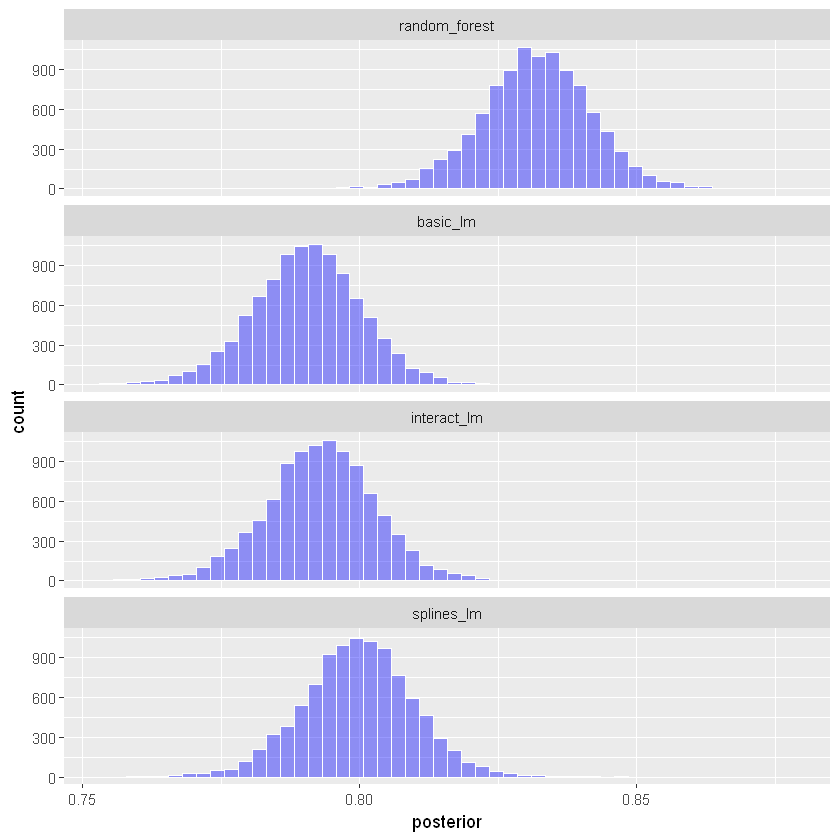

In [72]:
model_post %>% 
    mutate(model = forcats::fct_inorder(model)) %>%
    ggplot(aes(x = posterior)) + 
    geom_histogram(bins = 50, color = "white", fill = "blue", alpha = 0.4) + 
    facet_wrap(~ model, ncol = 1)

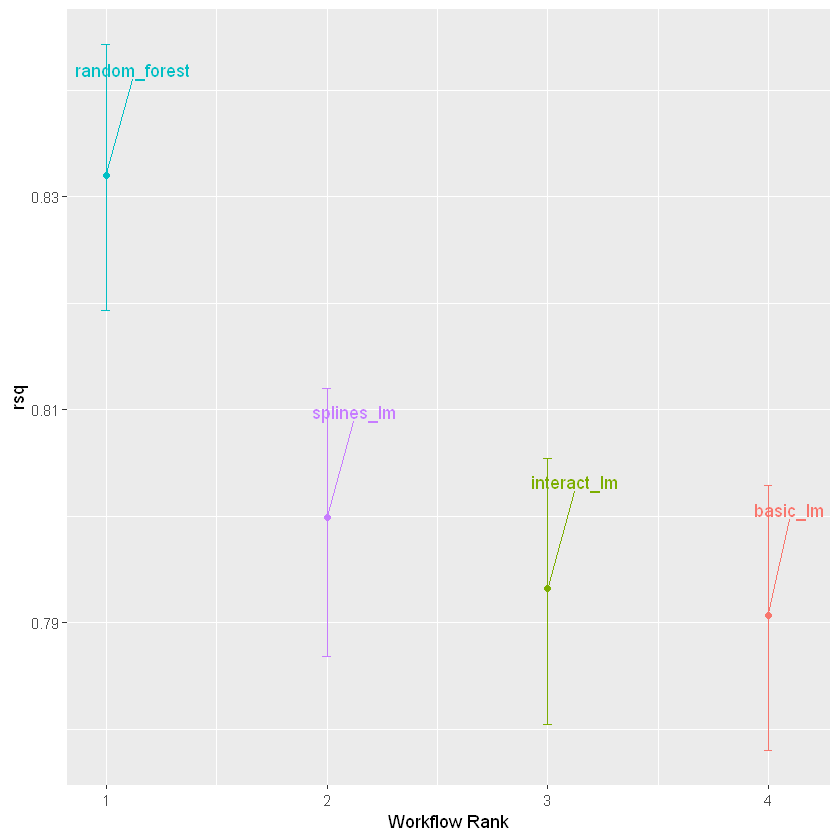

In [73]:
autoplot(rsq_anova) +
    geom_text_repel(aes(label = workflow), nudge_x = 1/8, nudge_y = 1/100) +
    theme(legend.position = "none")

<br>

#### **매개변수에 대한 사후 분포를 얻은 후에는 매개변수 조합에 대한 사후 분포를 얻는 것이 더 용이**
- **두 선형 회귀 모델을 비교하기 위해 평균의 차이에 관심이 있을 때,** 
    
    **차이의 사후분포는 개별 사후값에서 샘플링하고 차이를 취하여 계산**

#### `contrast_models()`

In [75]:
rqs_diff <- contrast_models(rsq_anova, 
                            list_1 = "splines_lm", list_2 = "basic_lm",
                            seed = 1104)

In [79]:
rqs_diff %>% head()

difference,model_1,model_2,contrast
<dbl>,<chr>,<chr>,<chr>
0.008844992,splines_lm,basic_lm,splines_lm vs. basic_lm
0.009232497,splines_lm,basic_lm,splines_lm vs. basic_lm
0.007087521,splines_lm,basic_lm,splines_lm vs. basic_lm
0.006893482,splines_lm,basic_lm,splines_lm vs. basic_lm
0.006286658,splines_lm,basic_lm,splines_lm vs. basic_lm
0.009115243,splines_lm,basic_lm,splines_lm vs. basic_lm


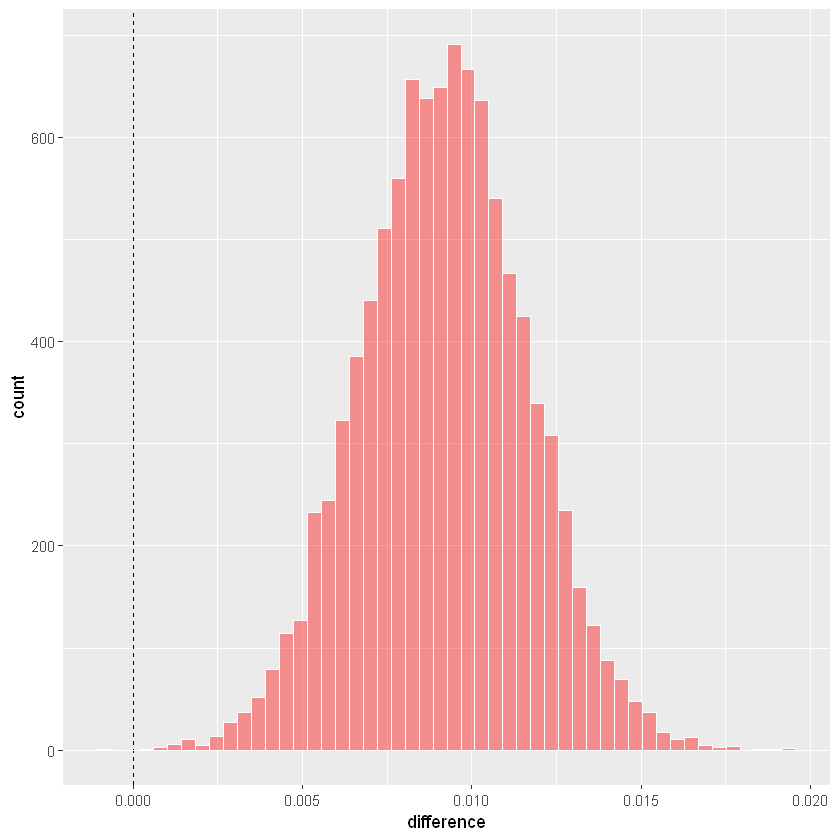

In [77]:
rqs_diff %>% 
    as_tibble() %>% 
    ggplot(aes(x = difference)) + 
    geom_vline(xintercept = 0, lty = 2) + 
    geom_histogram(bins = 50, color = "white", fill = "red", alpha = 0.4)

<br>

* 사후분포 차이는 중심이 0보다 큼 (스플라인 > 일반 다항회귀)
    - `probability` : 두 사후분포의 차이의 유의성
- 사후분포 차이의 평균은 0에 매우 가까운 값을 가짐

In [86]:
summary(rqs_diff) %>% 
  select(-starts_with("pract"))

contrast,probability,mean,lower,upper,size
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
splines_lm vs basic_lm,0.9999,0.009176724,0.005192076,0.01317674,0


- **사후분포 차이의 평균이 0.02일 가능성은 0에 가까움 (ROPE 추정치, Region Of Practical Equivalence)**
    
    $\rightarrow$ 실질적으로 두 분포의 차이가 의미가 없을 만큼 작음

In [89]:
summary(rqs_diff, size = 0.02) %>% 
    select(contrast, starts_with("pract"))

contrast,pract_neg,pract_equiv,pract_pos
<chr>,<dbl>,<dbl>,<dbl>
splines_lm vs basic_lm,0,1,0


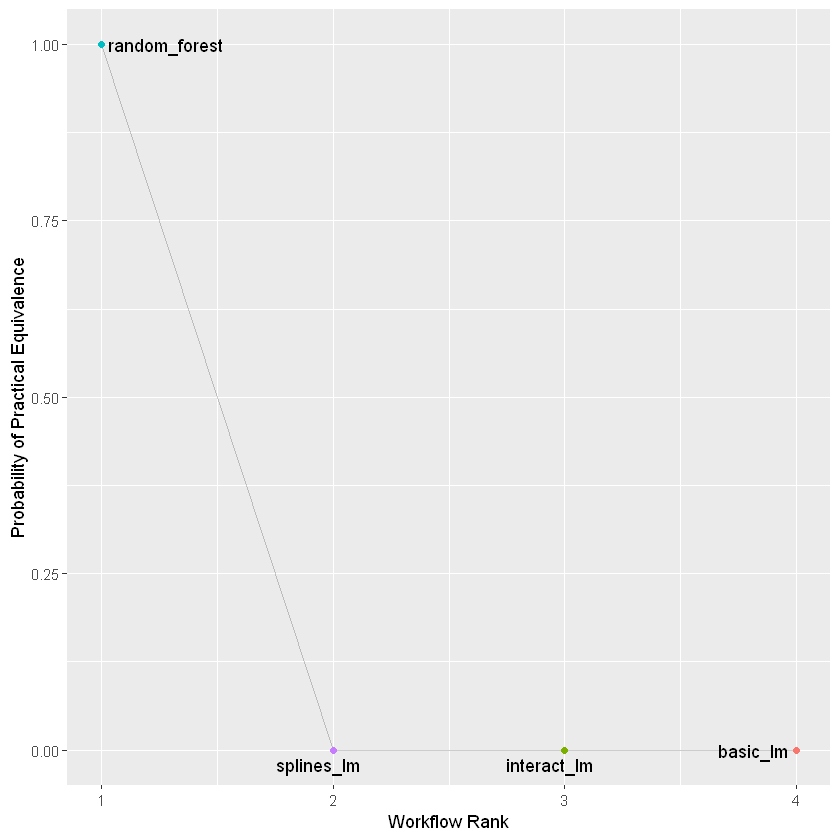

In [90]:
autoplot(rsq_anova, type = "ROPE", size = 0.02) +
    geom_text_repel(aes(label = workflow)) +
    theme(legend.position = "none")

<br>

### 리샘플링 횟수의 효과
- 리샘플링 횟수가 증가할수록, 추정의 정확도가 높아짐

<img src='https://www.tmwr.org/figures/intervals-over-replicates-1.png'>